In [7]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [10]:
tokenizer_dir = "../../../tokenizers"

languages = ("zh", "he", "ka", "ar", "ur", "hi", "mr", "ta", "te", "th", "el","ru", "bg", "sw", "vi","tr", "fr", "de", "es", "en")
languages_old_order = ("ar", "tr", "zh", "el", "es", "en", "sw", "hi", "mr", "ur", "ta", "te", "th", "ru", "bg", "he", "ka", "vi", "fr", "de")
multil_string = "ar-tr-zh-el-es-en-sw-hi-mr-ur-ta-te-th-ru-bg-he-ka-vi-fr-de"

alphas = ('0.25', )
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 120000
tok_type = "sp-unigram"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [11]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

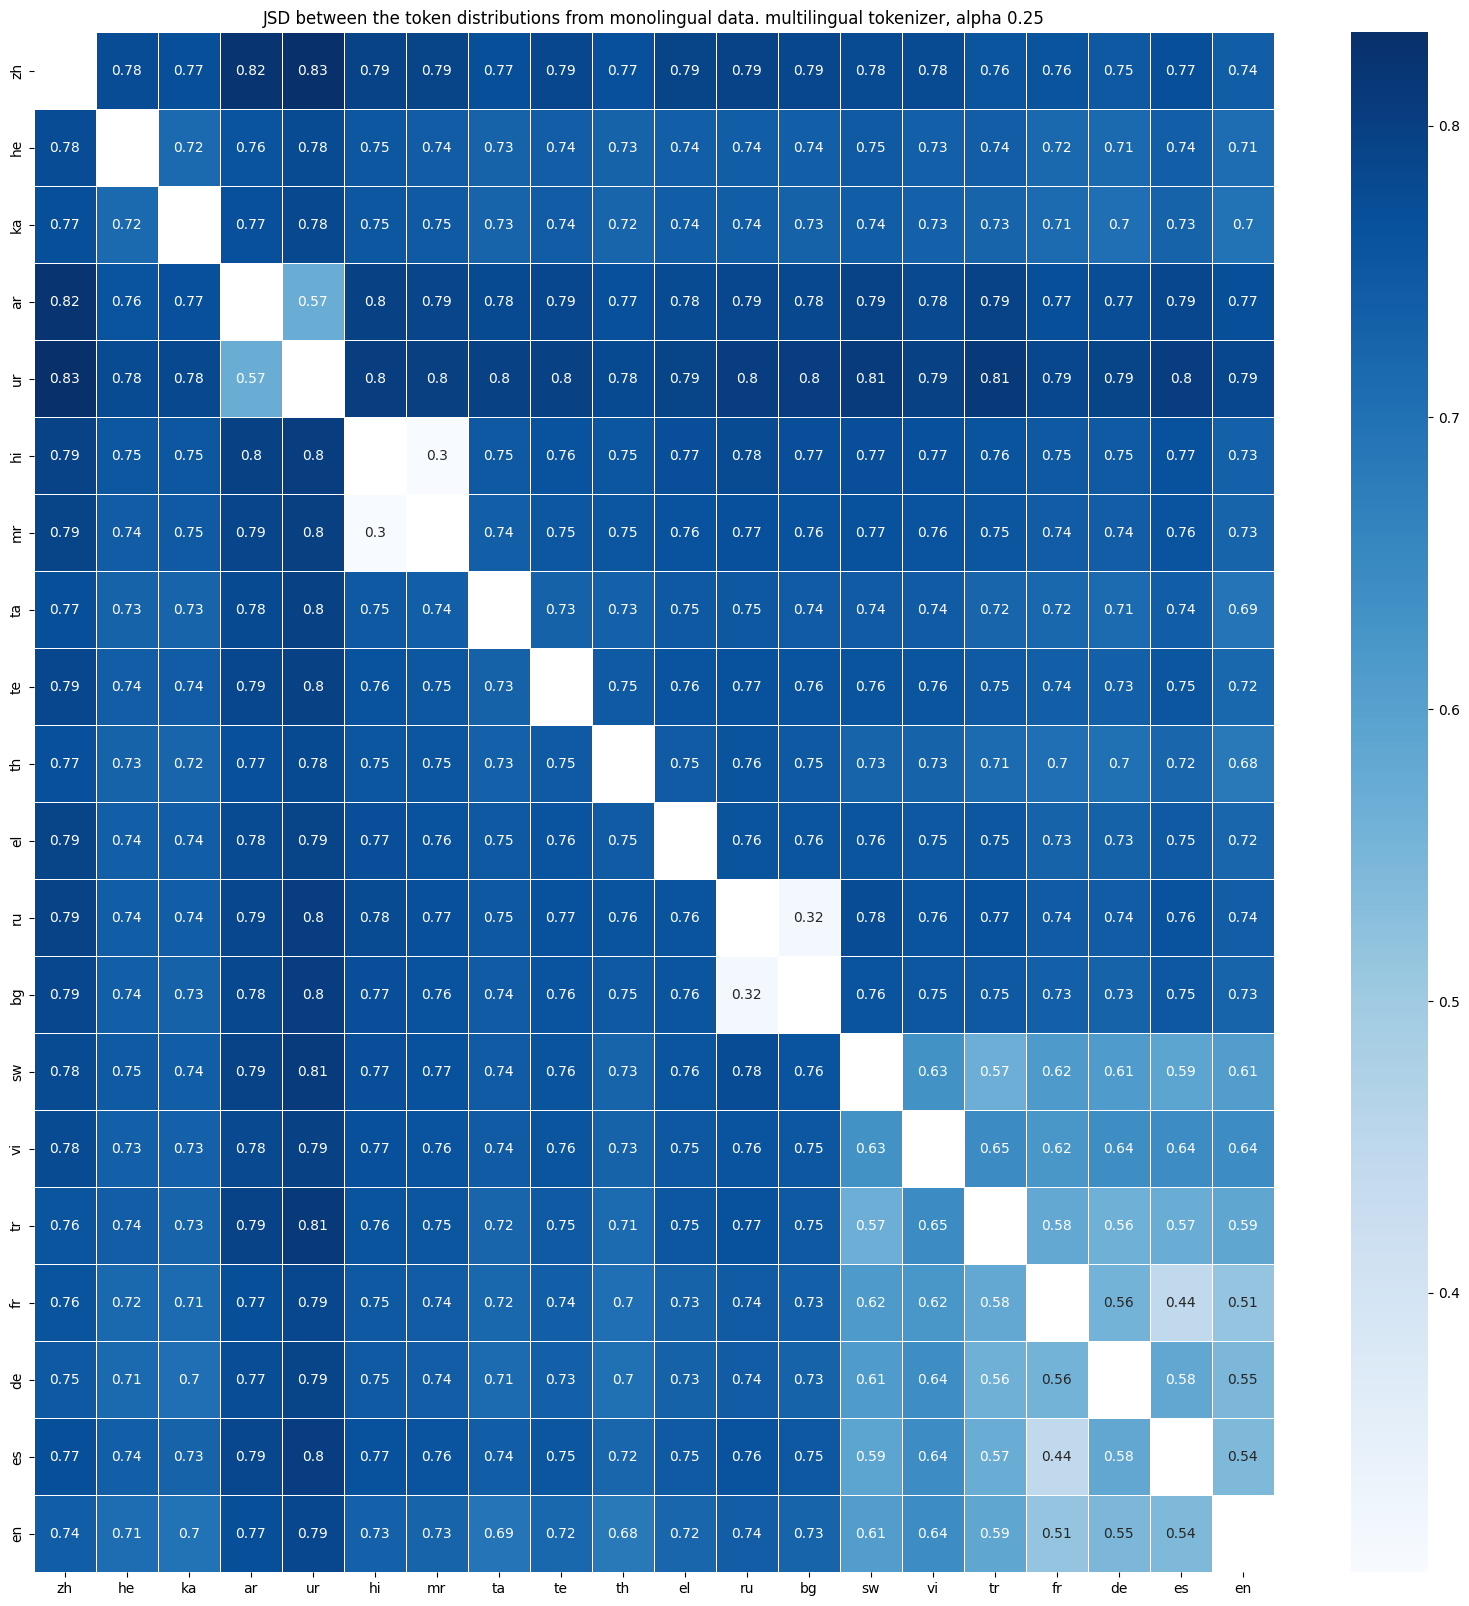

In [13]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2], base=2.) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(20, 20))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

In [22]:
# # plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
# fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
# for lang1, lang2 in itertools.product(languages, languages):
#     if lang1 == lang2:
#         continue
#     ax = axes[languages.index(lang2), languages.index(lang1)]
#     ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
#     ax.set_title(f"{lang1} - {lang2}")
#     # ax.set_xlabel("alpha")
#     # ax.set_ylabel("JS-divergence")
# fig.supxlabel("alpha")
# fig.supylabel("JS-divergence")
# plt.show()

- observation: the divergences never go higher with more data


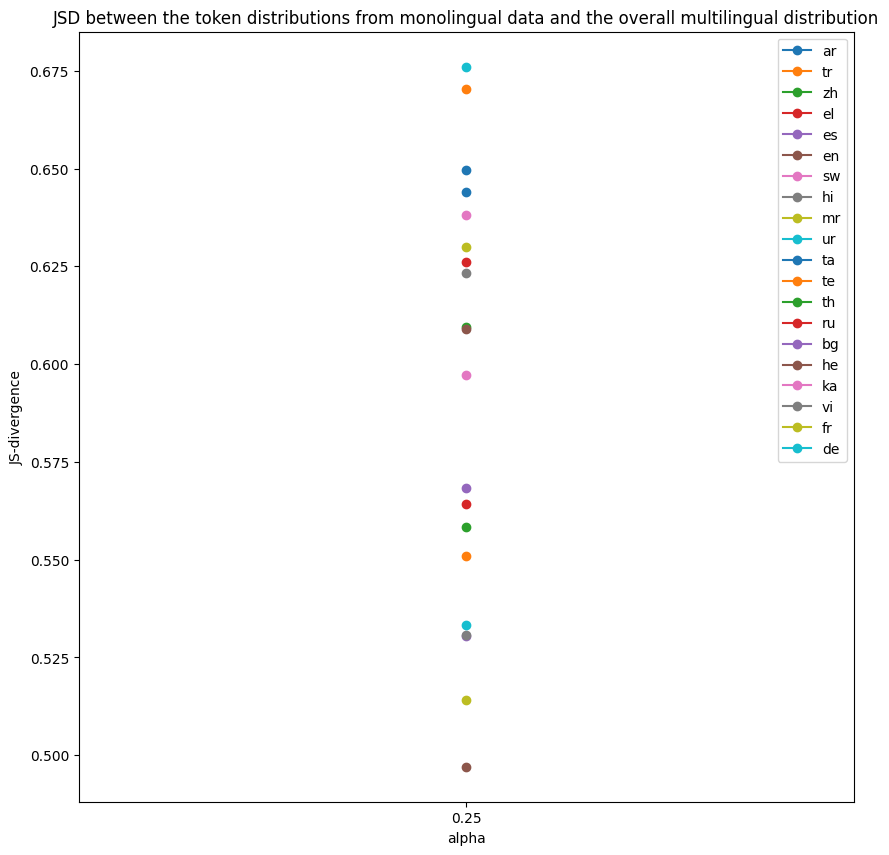

In [15]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

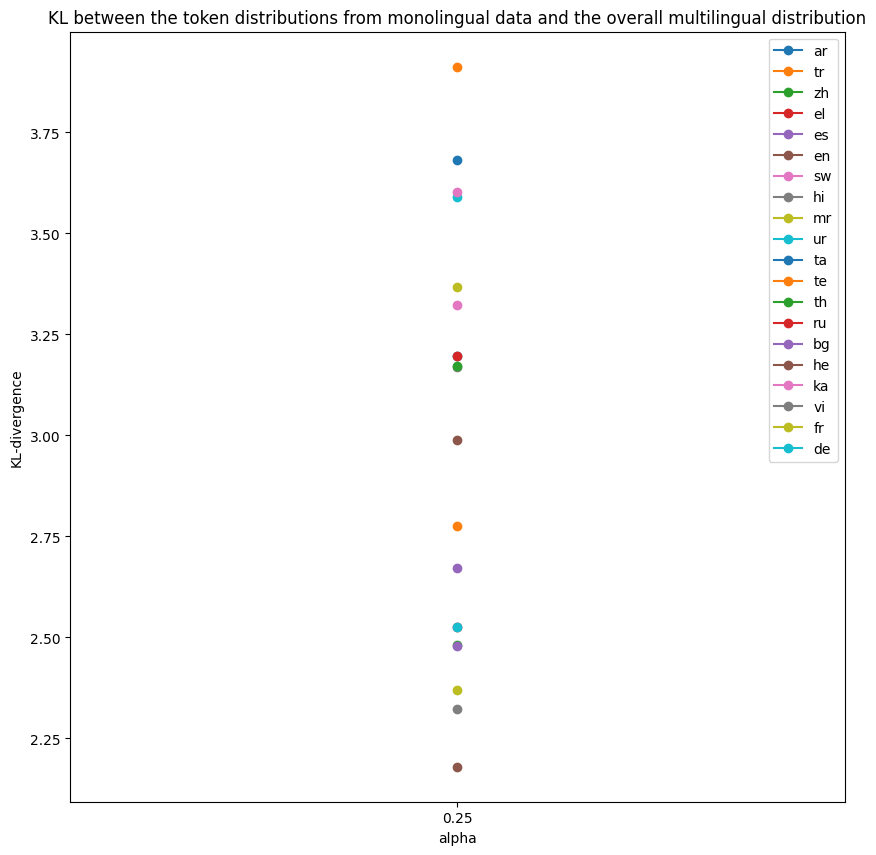

In [16]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.)

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

## Tokenizer profile plot PDFs

<Figure size 640x480 with 0 Axes>

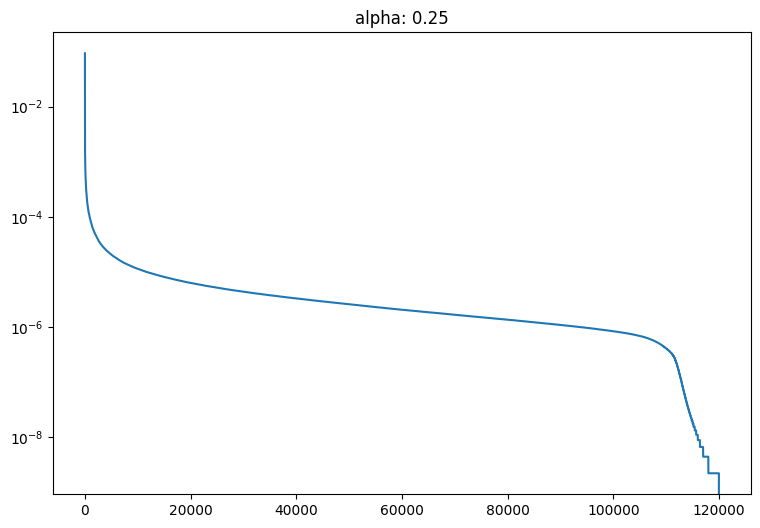

In [17]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(sorted_data)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    plt.show()


# For each language

<Figure size 640x480 with 0 Axes>

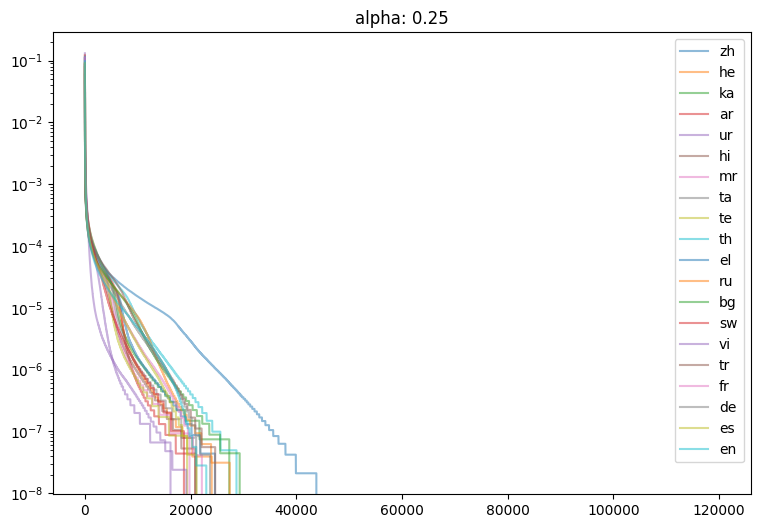

In [18]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(sorted_data, label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()

        

<Figure size 640x480 with 0 Axes>

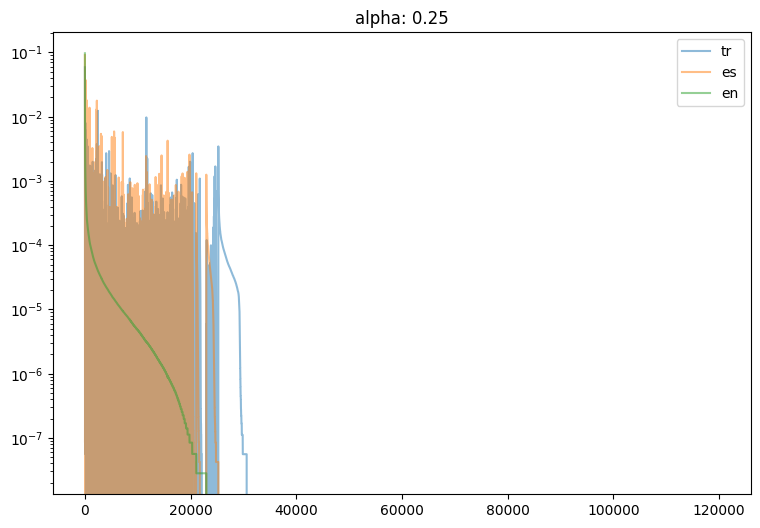

In [19]:
langugage_subset = ('tr','es', 'en')
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    index_sort_key = np.zeros_like(overall_token_dists[alpha])
    for lang_idx, lang in enumerate(langugage_subset):
        index_sort_key -= token_dists[alpha][lang] * pow(100000, lang_idx)
    index_sort = np.argsort(index_sort_key)
    for lang in langugage_subset:
        ax.plot(token_dists[alpha][lang][index_sort], label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()


# CDFs

<Figure size 640x480 with 0 Axes>

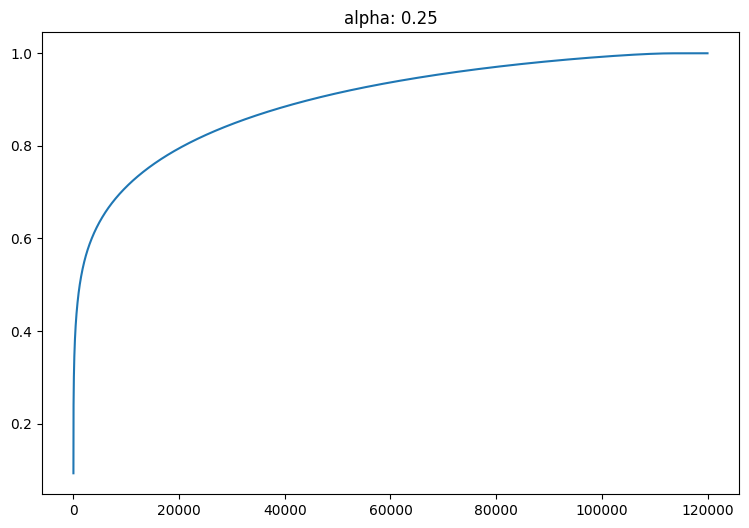

quatniles: 0.90, 0.95, 0.99, 0.999: [44890, 66748, 97196, 109788]
average rank: 12459


In [20]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(np.cumsum(sorted_data))

    ax.set_title(f"alpha: {alpha}")
    plt.show()



    percentile_idx = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
    avg_rang = np.sum(sorted_data * np.arange(len(sorted_data)))
    print(f"quatniles: 0.90, 0.95, 0.99, 0.999: {percentile_idx}")
    print(f"average rank: {np.round(avg_rang):.0f}")

<Figure size 640x480 with 0 Axes>

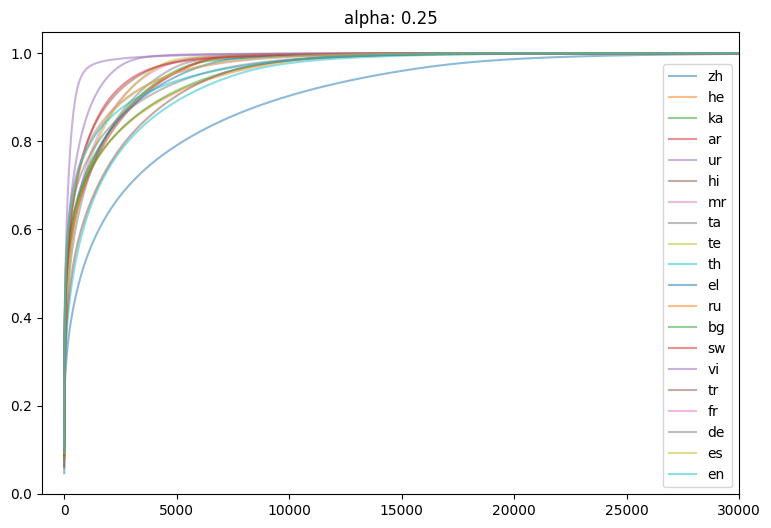

zh percentiles: 0.90, 0.95, 0.99, 0.999: [9773, 13862, 21267, 31511]
zh average rang: 3033
he percentiles: 0.90, 0.95, 0.99, 0.999: [3329, 4709, 7139, 14435]
he average rang: 978
ka percentiles: 0.90, 0.95, 0.99, 0.999: [3287, 4600, 8090, 18174]
ka average rang: 1008
ar percentiles: 0.90, 0.95, 0.99, 0.999: [3425, 4752, 6688, 11704]
ar average rang: 998
ur percentiles: 0.90, 0.95, 0.99, 0.999: [1346, 2001, 3459, 8353]
ur average rang: 431
hi percentiles: 0.90, 0.95, 0.99, 0.999: [2174, 3345, 6269, 13472]
hi average rang: 691
mr percentiles: 0.90, 0.95, 0.99, 0.999: [2578, 3676, 5985, 13058]
mr average rang: 821
ta percentiles: 0.90, 0.95, 0.99, 0.999: [3119, 4299, 7043, 14600]
ta average rang: 991
te percentiles: 0.90, 0.95, 0.99, 0.999: [2625, 3599, 5584, 12539]
te average rang: 832
th percentiles: 0.90, 0.95, 0.99, 0.999: [5291, 7543, 12844, 20833]
th average rang: 1680
el percentiles: 0.90, 0.95, 0.99, 0.999: [3485, 5096, 8186, 16421]
el average rang: 1023
ru percentiles: 0.90, 0.95

In [23]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    avg_rangs = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(np.cumsum(sorted_data), label=lang, alpha=0.5)
        percentile_idx[lang] = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
        avg_rangs[lang] = np.sum(sorted_data * np.arange(len(sorted_data)))
    ax.set_title(f"alpha: {alpha}")
    ax.set_xlim(-1000., 30000.)
    ax.legend()
    plt.show()
    for lang in languages:
        print(f"{lang} percentiles: 0.90, 0.95, 0.99, 0.999: {percentile_idx[lang]}")
        print(f"{lang} average rang: {np.round(avg_rangs[lang]):.0f}")
        